In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import requests

In [3]:
from tqdm import tqdm, trange

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [5]:
import math

# Using a neural network to compress a simple logo

import image from pokerbots website:

In [6]:
url = 'https://pokerbots.org/img/logo_with_title.png'
im = Image.open(requests.get(url, stream=True).raw)
im_arr = np.array(im)
im_arr = im_arr[:,:,:3]
im_arr.shape

(500, 500, 3)

normalize array values, originally integers in [0,255] --> floats in [0,1]:

In [7]:
im_normalized = im_arr / 255.0

display image using matplotlib

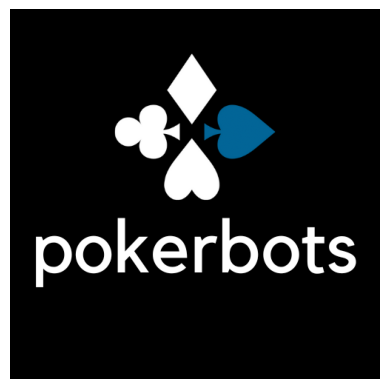

In [8]:
plt.axis('off')
plt.imshow(im_normalized)
plt.show()

we can get width and height of this image in pixels:

In [9]:
im_height, im_width = im_normalized.shape[0], im_normalized.shape[1]
print((im_height, im_width))

(500, 500)


There are a total of N pixels in the image with RGB values - we desire to predict a pixel's color based on it's position within the image.

As our inputs, we want an Nx2 array where each row represents a pixel's row and column position in the image:

In [10]:
inputs = np.array([[r, c] for r in range(im_height) for c in range(im_width)], dtype=np.float32)
print(inputs.shape)
print(inputs)

(250000, 2)
[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 ...
 [499. 497.]
 [499. 498.]
 [499. 499.]]


We can normalize these values to be in [0,1] instead:

In [11]:
inputs[:, 0] /= im_width
inputs[:, 1] /= im_height
print(inputs)

[[0.    0.   ]
 [0.    0.002]
 [0.    0.004]
 ...
 [0.998 0.994]
 [0.998 0.996]
 [0.998 0.998]]


As the outputs for our task, we want an Nx3 array where each row represents a pixel's RGB values

In [12]:
outputs = im_normalized.reshape(-1, 3).astype(np.float32) # Flatten the RGB array
print(outputs.shape)
print(outputs)

(250000, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


We can use `sklearn`'s library function to randomly split these sets of inputs and outputs into training and validation sets. We specify an 80%-20% partition.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(inputs, outputs, test_size=0.2, random_state=1)
print((X_train.shape, X_val.shape, y_train.shape, y_val.shape))

((200000, 2), (50000, 2), (200000, 3), (50000, 3))


Now we have our data prepared for Machine Learning! Here we will be fitting a neural network using PyTorch. To be ready for pytorch, we need to convert the objects (which are numpy arrays) into pytorch tensors, which are very similar to numpy arrays:

In [14]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

Let's create a pytorch neural network class, or hyperparameter specification of a neural network. We can then create instances of this class to train our model.

All that's required is to define a subclass of `nn.Module` and define two methods: `__init__`, which specifies the model's parameters, `forward`, which instructs how the model uses its parameters to compute outputs for a given input.



In this case, we'll define a simple 4 layer neural network that uses ReLU activation in between layers and Sigmoid activation on the outputs to ensure that the values are between 0 and 1, just like our normalized RGB values.

In [15]:
class SimpleNN(nn.Module):

    def __init__(self):
        super(SimpleNN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 64),   # Input: 2 (row, col) -> Hidden: 64
            nn.ReLU(),
            nn.Linear(64, 128), # Hidden: 64 -> Hidden: 128
            nn.ReLU(),
            nn.Linear(128, 3),  # Hidden: 128 -> Output: 3 (R, G, B)
            nn.Sigmoid()        # Ensure outputs are in [0, 1]
        )

    def forward(self, x):
        return self.network(x)

PyTorch's `nn` library provides lots of built in functions that makes it easy to plug and play different architectures, such as `nn.Linear` to connect layers, `nn.ReLU` and `nn.Sigmoid` for activations, and `nn.Sequential` to chain them all together. Feel free to change this neural network is designed - the number of layers, the number of neurons in each layer, or the activation functions! Just remember to make it able to receive our inputs (which are of dimension 2), and outputs (dimension 3).

Now we can instantiate a blank model to start our training!

In [16]:
model = SimpleNN()

Now we can define the way our training loop occurs!

Part of this involves choosing our loss `criterion` (we'll use MSE by default) and training `optimizer` (we'll use Adam by default). These can also be easily changed for other methods using pytorch's `nn` and `optim` libraries.

Finally, we choose some constants for our training procedure - `epochs`, which is the number of total passes through our training data, and `batch_size`, which is the size of the chunks that we perform each gradient descent step on. These constants can also be played with to see how they impact results.

In [17]:
def train(model, \
          X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, \
          criterion = nn.MSELoss, \
          optimizer = optim.Adam, \
          epochs = 10, \
          batch_size = 1024 \
          ):

    criterion = criterion()
    optimizer = optimizer(model.parameters())

    for epoch in trange(epochs): # Each pass through the training dataset

        # Set model to training mode
        model.train()

        # Shuffle the data before splitting into batches to make each epoch different
        permutation = torch.randperm(X_train_tensor.size(0))

        X_train_shuffled = X_train_tensor[permutation]
        y_train_shuffled = y_train_tensor[permutation]

        # Split the data into batches
        X_batches = torch.split(X_train_shuffled, batch_size)
        y_batches = torch.split(y_train_shuffled, batch_size)

        # Iterate through each training batch
        for X_batch, y_batch in zip(X_batches, y_batches):

        # for i in range(0, X_train_tensor.size(0), batch_size):

        #     indices = permutation[i:i+batch_size]
        #     X_batch, y_batch = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # Print performance after latest epoch
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

In [19]:
train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.0531, Validation Loss: 0.0638
Epoch 2/10, Training Loss: 0.0817, Validation Loss: 0.0618
Epoch 3/10, Training Loss: 0.0754, Validation Loss: 0.0610
Epoch 4/10, Training Loss: 0.0520, Validation Loss: 0.0601
Epoch 5/10, Training Loss: 0.0524, Validation Loss: 0.0591
Epoch 6/10, Training Loss: 0.0712, Validation Loss: 0.0581
Epoch 7/10, Training Loss: 0.0633, Validation Loss: 0.0567
Epoch 8/10, Training Loss: 0.0627, Validation Loss: 0.0555
Epoch 9/10, Training Loss: 0.0584, Validation Loss: 0.0540
Epoch 10/10, Training Loss: 0.0700, Validation Loss: 0.0528


The components of the loop are mostly self explanatory, except for what pytorch does internally during each training batch:

- We first do a forward pass to compute the model's predictions on the batch: `model(X_batch)`
- Next we evaluate their loss of these predictions using our criterion: `criterion(predictions, y_batch)`
- Behind the scenes, pytorch stores the full sequence of operations from the input to the final loss value.
- Pytorch is then able to compute gradients using the chain rule by tracing this sequence backwards (aka backward pass) using `loss.backward()`.
- The optimizer object pays attention to the gradients for each parameter, and uses these newly calculated values to take a gradient step in `optimizer.step()`, but we must first reset the gradient values using `optimizer.zero_grad()` before running the backward pass.

Keeping track of all these changes only happens when the model is in training mode, which we set using `model.train()`. If we're not training the model and only want to interact with the model for the purpose of getting its outputs, we set it to evaluation mode using `model.eval()`. This should be done whenever we want to briefly evaluate the model throughout training, or use the model after it's done training, such as with a sample input:





In [20]:
model.eval()
sample_input = torch.tensor([[0.5, 0.5]])
sample_prediction = model(sample_input).detach().numpy()
print(sample_prediction)

[[0.47908393 0.4629024  0.4543071 ]]


We can create a helper function to display what the model's predicted pixels are for our original input - essentially viewing the compressed image stored within the model's neural network:

In [21]:
def test_show(model, inputs, im_width, im_height):
    model.eval()
    inputs_tensor = torch.tensor(inputs)
    predictions = model(inputs_tensor).detach().numpy()
    predicted_image = predictions.reshape(im_width, im_height, 3)
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.show()

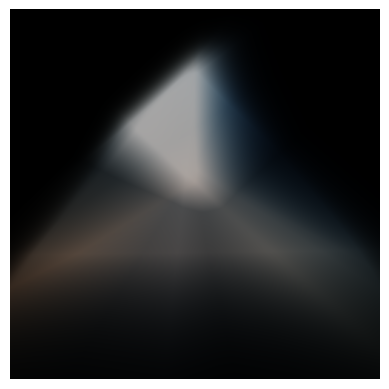

In [22]:
test_show(model, inputs, im_width, im_height)

We can sort of see similarities with the original image, but it's not great. In fact, we can see some artifacts given by the constrained set of input features. While neural networks are powerful in that they help construct useful features, they still stand to benefit greatly from useful feature selection and construction.

## Improving with constructed sinusoidal features

In this section, we explore the potential of a modified neural network architecture that adds sines and cosines of pixel coordinates across a few frequencies:

In [23]:
class EnhancedNN(nn.Module):
    def __init__(self, K = 10):
        super(EnhancedNN, self).__init__()

        self.K = K # how much we scale the sinusoidal features
        total_features = 2 + 4 * K # two original + sin/cos on row/col from 1-K

        self.network = nn.Sequential(
            nn.Linear(total_features, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract row and col (first two features)
        row_col = x[:, :2]  # [Batch, 2]
        row = row_col[:, 0:1]  # Isolate row feature
        col = row_col[:, 1:2]  # Isolate col feature

        # Generate sinusoidal features
        sin_features = []
        for scale in range(1, self.K + 1):  # Frequencies 1-K
            freq = math.pi * scale
            sin_features.append(torch.sin(row * freq))
            sin_features.append(torch.cos(row * freq))
            sin_features.append(torch.sin(col * freq))
            sin_features.append(torch.cos(col * freq))

        sin_features = torch.cat(sin_features, dim=-1)
        augmented_input = torch.cat((row_col, sin_features), dim=-1)

        output = self.network(augmented_input)
        return output


We observe that the results are much better:

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.0396, Validation Loss: 0.0407
Epoch 2/10, Training Loss: 0.0339, Validation Loss: 0.0258
Epoch 3/10, Training Loss: 0.0239, Validation Loss: 0.0203
Epoch 4/10, Training Loss: 0.0263, Validation Loss: 0.0169
Epoch 5/10, Training Loss: 0.0086, Validation Loss: 0.0138
Epoch 6/10, Training Loss: 0.0063, Validation Loss: 0.0123
Epoch 7/10, Training Loss: 0.0168, Validation Loss: 0.0103
Epoch 8/10, Training Loss: 0.0053, Validation Loss: 0.0097
Epoch 9/10, Training Loss: 0.0092, Validation Loss: 0.0098
Epoch 10/10, Training Loss: 0.0044, Validation Loss: 0.0079


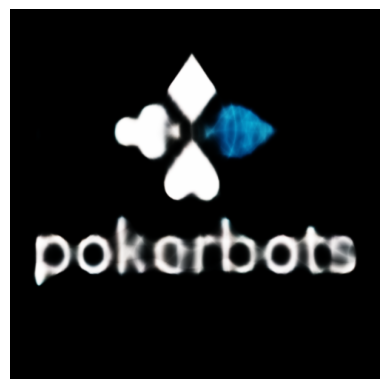

In [24]:
model = EnhancedNN()
train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
test_show(model, inputs, im_width, im_height)

# complex image

Now that we've seen how these these neural nets perform on a simple flat logo image, let's try a more complex photo image:

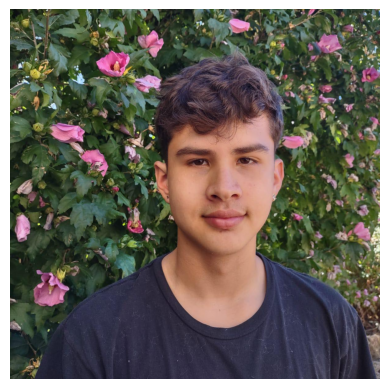

In [25]:
url = 'https://pokerbots.org/img/headshots/paco.png'
im = Image.open(requests.get(url, stream=True).raw)
im_normalized = np.array(im)[:,:,:3] / 255.0
plt.axis('off')
plt.imshow(im_normalized)
plt.show()

We can run all the exact same code to get our training and validation sets.

In [26]:
im_height, im_width = im_normalized.shape[0], im_normalized.shape[1]
inputs = np.array([[r, c] for r in range(im_height) for c in range(im_width)], dtype=np.float32)
inputs[:, 0] /= im_width
inputs[:, 1] /= im_height
outputs = im_normalized.reshape(-1, 3).astype(np.float32)

print((im_height, im_width))
print(inputs.shape)
print(outputs.shape)

X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = [\
                torch.tensor(array) for array in train_test_split(inputs, outputs, test_size=0.2, random_state=1)]

(1200, 1200)
(1440000, 2)
(1440000, 3)


Just like before, the simple neural network fails to recreate any fine details, but the general blurry patches of color can be recognized as matching the original image:

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.0258, Validation Loss: 0.0242
Epoch 2/10, Training Loss: 0.0213, Validation Loss: 0.0219
Epoch 3/10, Training Loss: 0.0216, Validation Loss: 0.0212
Epoch 4/10, Training Loss: 0.0214, Validation Loss: 0.0208
Epoch 5/10, Training Loss: 0.0204, Validation Loss: 0.0203
Epoch 6/10, Training Loss: 0.0205, Validation Loss: 0.0201
Epoch 7/10, Training Loss: 0.0210, Validation Loss: 0.0198
Epoch 8/10, Training Loss: 0.0232, Validation Loss: 0.0198
Epoch 9/10, Training Loss: 0.0215, Validation Loss: 0.0197
Epoch 10/10, Training Loss: 0.0199, Validation Loss: 0.0196


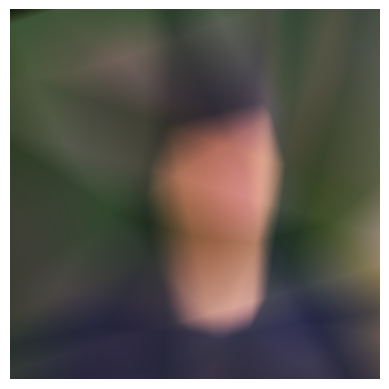

In [27]:
model = SimpleNN()
train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
test_show(model, inputs, im_width, im_height)

Despite the image's increased perceived complexity, the same enhanced neural net with the expanded set of sinusoidal features still does surprisingly well at faithfully recreating the original image. General results from signal processing suggests that sinusoidal transformations of pixel position may be useful features for photographic images.

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.0090, Validation Loss: 0.0101
Epoch 2/10, Training Loss: 0.0085, Validation Loss: 0.0090
Epoch 3/10, Training Loss: 0.0091, Validation Loss: 0.0085
Epoch 4/10, Training Loss: 0.0082, Validation Loss: 0.0080
Epoch 5/10, Training Loss: 0.0074, Validation Loss: 0.0078
Epoch 6/10, Training Loss: 0.0071, Validation Loss: 0.0076
Epoch 7/10, Training Loss: 0.0077, Validation Loss: 0.0075
Epoch 8/10, Training Loss: 0.0072, Validation Loss: 0.0072
Epoch 9/10, Training Loss: 0.0074, Validation Loss: 0.0071
Epoch 10/10, Training Loss: 0.0066, Validation Loss: 0.0070


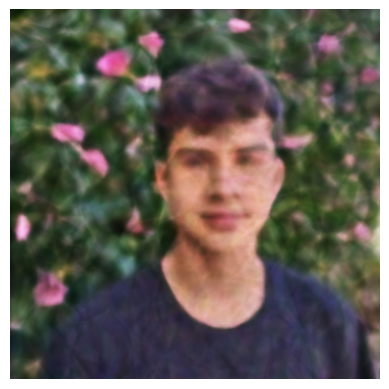

In [28]:
model = EnhancedNN()
train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
test_show(model, inputs, im_width, im_height)

However, a model's test results are only good when the inputs are similar to those in training. If we try and predict pixel values outside the image boundaries of [0,1] in each coordinate (here we transform so they range from [-0.5, 1.5]), they don't make much sense in terms of what we'd expect to see outside of the original image's frame. But note that artifacts such as similar colors to the frame's interior are observable outside the frame.

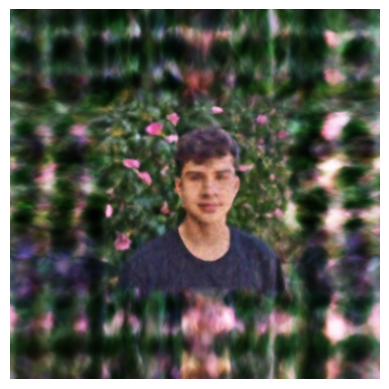

In [29]:
test_show(model, inputs * 2 - 0.5, im_width, im_height)